In this task you will develop a system to detect irony in text. We will use the data from the SemEval-2018 task on irony detection.

```csv
Tweet index     Label   Tweet text
1       1       Sweet United Nations video. Just in time for Christmas. #imagine #NoReligion  http://t.co/fej2v3OUBR
2       1       @mrdahl87 We are rumored to have talked to Erv's agent... and the Angels asked about Ed Escobar... that's hardly nothing    ;)
3       1       Hey there! Nice to see you Minnesota/ND Winter Weather 
4       0       3 episodes left I'm dying over here
```


In [2]:
#Importing all necessary libraries.

import pandas as pd
import numpy as np
import warnings
import re
import nltk
from nltk.corpus import stopwords

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)
from nltk import ngrams

# Task 1

Read all the data and find the size of vocabulary of the dataset (ignoring case) and the number of positive and negative examples.

In [5]:
#Below function split the tweet into a bag of words preserving all delimiters.

default_stop_words = nltk.corpus.stopwords.words('english')
stopwords = set(default_stop_words)

def create_tuples(filename):
    #open file from location
    data = open(filename)
    #list to store bag of words.
    dataset = []
    for line in data:
        # Removing new line character from the end of the tweet.
        line = line.rstrip("\n")
        #Ignoring 1st line having labels.
        if(not line.startswith("Tweet")):
            #Split each line by tab
            l = line.split('\t')
            # split tweet label by white-space
            bow = l[2].split(' ')
            wordlist = []
            #Iterating over every word in a tweet
            for everyword in bow:
                # handling special case of web address: retaining all the charaters that startsWith 'http'
                if(everyword.startswith("http")):
                    w = everyword.split(":")
                    wordlist.append(w[0].lower())
                    wordlist.append(':')
                    wordlist.append(w[1].lower())
                else:
                    #using python regex to split each word into three groups (before delimiter - delimiter - after delimiter)
                    #adding all three elements to the list
                    #list of delimiters provided via regex
                    regex = re.compile(r'(\w*)([!,@,#,$,%,^,&,*,\',\",;,,.]*)(\w*)')
                    w = re.search(regex, everyword)
                    if(w.group(1)!=''):
                        wordlist.append(w.group(1).lower())
                    if(w.group(2)!=''):
                        wordlist.append(w.group(2).lower())
                    if(w.group(3)!=''):
                        wordlist.append(w.group(3).lower())
            row = (int(l[0]),int(l[1]),wordlist)
            dataset.append(row)
    return(dataset)

In [6]:
inputfile='data/SemEval2018-T3-train-taskA.txt' #Location of the file
tweets=create_tuples(inputfile)

#Funtion to create unique list of tokens
vocab=set([])
for tweet in tweets:
    for word in tweet[2]:
        vocab.add(word)

print ("Vocabulary size is "+str(len(vocab)))

#Segregating positive and negative examples
pos=0
neg=0
for tweet in tweets:
    if tweet[1]==1:
        pos=pos+1
    else:
        neg=neg+1

print ("No. of positive examples: "+str(pos))
print ("No. of negative examples: "+str(neg))

Vocabulary size is 12424
No. of positive examples: 1911
No. of negative examples: 1923


# Task 2

Develop a classifier using the Naive Bayes model to predict if an example is ironic. The model should convert each Tweet into a bag-of-words and calculate

$p(\text{Ironic}|w_1,\ldots,w_n) \propto \prod_{i=1,\ldots,n} p(w_i \in \text{tweet}| \text{Ironic}) p(\text{Ironic})$

$p(\text{NotIronic}|w_1,\ldots,w_n) \propto \prod_{i=1,\ldots,n} p(w_i \in \text{tweet}| \text{NotIronic}) p(\text{NotIronic})$

You should use add-alpha smoothing to calculate probabilities

In [0]:
#Function to facilitate add alpha smoothing in the case where words are not present in the data set.
#Function to calculate no. of unseen words in a vocabulary.
#In our example we are calculating no of words from test data set which are not present in train data set.

def calculate_unseen_words_count(X_train,X_test):
    
    train_word_list=[]
    for index, row in X_train.iterrows():
        for word in row['text']:
            train_word_list.append(word)
            
    word_count=0
    for index, row in X_test.iterrows():
        for word in row['text']:
            if word not in train_word_list:
                word_count=word_count+1
    
    return word_count
            

In [0]:
#Custom built classifier to predict if an example is ironic.

class NayesBayes:
    
    #initialize all parameters
    def __init__(self, alpha=0.03):
        # Initialising all default values
        self.alpha = alpha
        self.irony_tweets=[]
        self.non_irony_tweets=[]
        self.vocab=set([])

    # fit model to train data
    # Segregate into irony and non-irony tweets.
    # Also, creating vocab of unique tokens.
    def fit(self, X, y):
        pos=0
        neg=0
        irony_tweets=[]
        non_irony_tweets=[]
        for index, row in X.iterrows():
            if y[index]==1:
                pos=pos+1
                for word in row['text']:
                    self.irony_tweets.append(word)
            else:
                neg=neg+1
                for word in row['text']:
                    self.non_irony_tweets.append(word)
        
        for index, row in X.iterrows():
            for word in row['text']:
                self.vocab.add(word)
                
        #Probability of Irony tweets
        self.p_tweet_irony=pos/len(self.irony_tweets)
        #Probability of non Irony tweets
        self.p_tweet_non_irony=neg/len(self.non_irony_tweets)
        
    #Estimating probability of the tweet being irony
    #Add Alpha smoothing added
    def _irony_prob(self,tweet,unseen_words_count):
        p_irony=1
        for word in tweet:
            word_count=0
            for token in self.irony_tweets:
                if word == token:
                    word_count=word_count+1
            if word_count > 0:
                p_irony=p_irony*((word_count+(self.alpha*len(self.vocab))))/(len(self.irony_tweets)+self.alpha*(len(self.vocab)+unseen_words_count))
            else:
                p_irony=p_irony*(((self.alpha*unseen_words_count)))/(len(self.irony_tweets)+self.alpha*(len(self.vocab)+unseen_words_count))
        return p_irony*self.p_tweet_irony
    
    #Estimating probability of the tweet being non irony
    #Add Alpha smoothing added
    def _non_irony_prob(self,tweet,unseen_words_count):
        p_non_irony=1
        for word in tweet:
            word_count=0
            for token in self.non_irony_tweets:
                if word == token:
                    word_count=word_count+1
            if word_count > 0:
                p_non_irony=p_non_irony*((word_count+(self.alpha*len(self.vocab))))/(len(self.non_irony_tweets)+self.alpha*(len(self.vocab)+unseen_words_count))
            else:
                p_non_irony=p_non_irony*(((self.alpha*unseen_words_count)))/(len(self.non_irony_tweets)+self.alpha*(len(self.vocab)+unseen_words_count))
        return p_non_irony*self.p_tweet_non_irony
    
    # predict values for binary model
    def predict(self, X, unseen_words_count):
        pred_result=[]
        count=0
        for index, row in X.iterrows():
            
            #Get probablity of the tweet being irony
            irony=self._irony_prob(row['text'],unseen_words_count)
            #Get probablity of the tweet being non irony
            non_irony=self._non_irony_prob(row['text'],unseen_words_count)
            
            #if irony value is greater than the non-irony than the predicted result is irony or vice-versa.
            if irony>non_irony:
                pred_result.append(1)
            else:
                pred_result.append(0)
            count=count+1
        return pred_result


# Task 3

Divide the data into a training and test set and justify your split.

Choose a suitable evaluation metric and implement it. Explain why you chose this evaluation metric.


Evaluate the method in Task 2 according to this metric.

### Evaluation Metrics

#### Confusion Matrix
* A confusion matrix is a summary of prediction results on a classification problem.
* The number of correct and incorrect predictions are summarized with count values and broken down by each class.


* We can learn a lot from the confusion matrix.

    * The total actual irony tweets in the dataset is the sum of the values (464 + 661)
    * The total actual non irony tweets in the dataset is the sum of values (288 + 121).
    * The correct values are organized in a diagonal line from top left to bottom-right of the matrix (288 + 661).
    * More errors were made by predicting irony tweets as non irony than predicting non irony as irony.


#### ROC Curve: 
* An ROC curve is the most commonly used way to visualize the performance of a binary classifier, and Area under curve (AUC) is the way to summarize its performance in a single number. 
* A classifier that does a very good job separating the classes will have an ROC curve that hugs the upper left corner of the plot. Conversely, a classifier that does a very poor job separating the classes will have an ROC curve that is close to this black diagonal line.
* In our case, the curve is close to the diagonal and so the peformance of our classifier is low.

In [0]:
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

def evaluate_performance(y_test, y_pred):
    
    y_pred=np.array(y_pred)
    y_test=np.array(y_test)
    
    df_confusion = confusion_matrix(y_test, y_pred)
    print ("The confusion matrix: \n")
    print (df_confusion)
    TP=df_confusion.iloc[0][0]
    TN=df_confusion.iloc[1][1]
    FP=df_confusion.iloc[0][1]
    FN=df_confusion.iloc[1][0]
    print ()
    print ("Accuracy: %.5f" % ((TP + TN) / (TP + TN + FP + FN)))
    print ("Error Rate: %.2f" % ((FP + FN) / (TP + TN + FP + FN)))
    print ("Precision: %.2f" % (TP / (TP + FP)))
    print ("F-measure: %.2f" % (2 / ( (1 / (TP / (TP + FP))) + (1 / (TP/(TP + FN))) )))
    print ()
    print ("ROC Curve:")
    FPR, TPR, threshold = metrics.roc_curve(y_test, y_pred)
    plt.title('Irony Detection')
    plt.plot(FPR, TPR, 'b', label = 'AUC = %0.2f' % metrics.auc(FPR, TPR))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def confusion_matrix(y_test, y_pred):
    y_actu = pd.Series(y_test, name='Gold')
    y_pred = pd.Series(y_pred, name='Predicted')
    return pd.crosstab(y_actu, y_pred, margins=True)

The confusion matrix: 

Predicted    0     1   All
Gold                      
0          288   464   752
1          121   661   782
All        409  1125  1534

Accuracy: 0.61864
Error Rate: 0.38
Precision: 0.38
F-measure: 0.50

ROC Curve:


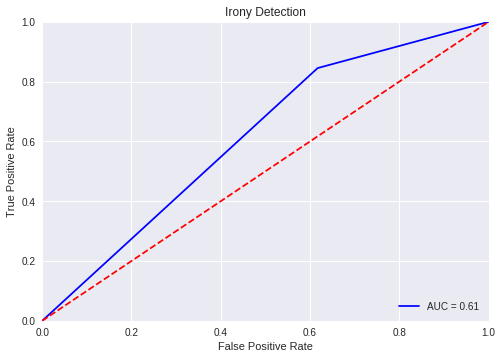

In [0]:
#Importing libraries from scikit learn

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#Using pandas to create data frame
ds = pd.DataFrame(tweets, columns=["index","label","text"])

#Creating Feature set(X) and Class variable (y)
y = ds['label']
X = ds.drop('label',axis=1)

# Splitting data set into training and test samples.
# Justification:
# Any train-test split which has more data in the training set will most likely give you better accuracy 
# as calculated on that test set. Normally 60% of the available data is allocated for training and the 
# remaining 40% data are for the test data sets. Partitioning ratio is an important aspect and one must 
# ensure that the training dataset should include all possible patterns used for defining the problem. 
# Hence, one must shuffle data before applying any split strategy. If you rather want a good estimate of 
# your real error, make the test set bigger.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42, shuffle=True)

#Retrieving unseen words count
unseen_words_count=calculate_unseen_words_count(X_train, X_test)

#Creating model object
model = NayesBayes(0.02)
#Fit model to training data
model.fit(X_train,y_train)
#Predicting result of test data
y_pred=model.predict(X_test, unseen_words_count)
#Evaluating model performance
evaluate_performance(y_test, y_pred)

In [0]:
import random

#Generating train and test data as per the desired format required by the model.
def task3():
    random.seed(101)
    train_size = int(round(len(tweets)*0.7,0))
    train = random.sample(tweets, train_size)
    test = []
    for row in tweets:
        if row not in train:
            test.append(row)
            
    return(train,test)


# Task 4

Run the following code to generate a model from your training set. The training set should be in a variable  called `train` and is assumed to be of the form:

```
[(1, 1, ['sweet', 'united', 'nations', 'video', '.', 'just', 'in', 'time', 'for', 'christmas', '.', '#', 'imagine', '#', 'noreligion', 'http', ':', '//t.co/fej2v3oubr']), 
 (2, 1, ['@', 'mrdahl87', 'we', 'are', 'rumored', 'to', 'have', 'talked', 'to', 'erv', "'s", 'agent', '...', 'and', 'the', 'angels', 'asked', 'about', 'ed', 'escobar', '...', 'that', "'s", 'hardly', 'nothing', ';', ')']), 
 (3, 1, ['hey', 'there', '!', 'nice', 'to', 'see', 'you', 'minnesota/nd', 'winter', 'weather']), 
 (4, 0, ['3', 'episodes', 'left', 'i', "'m", 'dying', 'over', 'here']), 
 ...
]
 ```



In [0]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Embedding, Dropout, TimeDistributed
from keras.layers import LSTM
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import numpy as np

## These values should be set from Task 3
train, test = task3()

def make_dictionary(train, test):
    dictionary = {}
    for d in train+test:
        for w in d[2]:
            if w not in dictionary:
                dictionary[w] = len(dictionary)
    return dictionary

class KerasBatchGenerator(object):
    def __init__(self, data, num_steps, batch_size, vocabulary, skip_step=5):
        self.data = data
        self.num_steps = num_steps
        self.batch_size = batch_size
        self.vocabulary = vocabulary
        self.current_idx = 0
        self.current_sent = 0
        self.skip_step = skip_step

    def generate(self):
        x = np.zeros((self.batch_size, self.num_steps))
        y = np.zeros((self.batch_size, self.num_steps, 2))
        while True:
            for i in range(self.batch_size):
                # Choose a sentence and position with at lest num_steps more words
                while self.current_idx + self.num_steps >= len(self.data[self.current_sent][2]):
                    self.current_idx = self.current_idx % len(self.data[self.current_sent][2])
                    self.current_sent += 1
                    if self.current_sent >= len(self.data):
                        self.current_sent = 0
                # The rows of x are set to values like [1,2,3,4,5]
                x[i, :] = [self.vocabulary[w] for w in self.data[self.current_sent][2][self.current_idx:self.current_idx + self.num_steps]]
                # The rows of y are set to values like [[1,0],[1,0],[1,0],[1,0],[1,0]]
                y[i, :, :] = [[self.data[self.current_sent][1], 1-self.data[self.current_sent][1]]] * self.num_steps
                self.current_idx += self.skip_step
            yield x, y

# Hyperparameters for model
vocabulary = make_dictionary(train, test)
num_steps = 5
batch_size = 20
num_epochs = 50 # Reduce this if the model is taking too long to train (or increase for performance)
hidden_size = 50 # Increase this to improve perfomance (or increase for performance)
use_dropout=True

# Create batches for RNN
train_data_generator = KerasBatchGenerator(train, num_steps, batch_size, vocabulary,
                                           skip_step=num_steps)
valid_data_generator = KerasBatchGenerator(test, num_steps, batch_size, vocabulary,
                                           skip_step=num_steps)

# A double stacked LSTM with dropout and n hidden layers
model = Sequential()
model.add(Embedding(len(vocabulary), hidden_size, input_length=num_steps))
model.add(LSTM(hidden_size, return_sequences=True))
model.add(LSTM(hidden_size, return_sequences=True))
if use_dropout:
    model.add(Dropout(0.5))
model.add(TimeDistributed(Dense(2)))
model.add(Activation('softmax'))

# Set optimizer and build model
optimizer = Adam()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

# Train the model
model.fit_generator(train_data_generator.generate(), len(train)//(batch_size*num_steps), num_epochs,
                        validation_data=valid_data_generator.generate(),
                        validation_steps=len(test)//(batch_size*num_steps))

# Save the model
model.save("final_model_old.hdf5")

In [0]:
#Splitting tweets into combination of 5 words sequentially.
def get_ngrams(tweet):
      tweet_comb_list=[]
    
      l=len(tweet)
      if l<5:
        count=0
        while len(tweet)<5:
          tweet.append(tweet[count])
          if count==(l-1):
            count=0
          else:
            count=count+1
            
      set_of_words = ' '.join(tweet)
      set_of_words = set_of_words.lstrip(' ')
      fivegrams = ngrams(set_of_words.split(),5)
      for gram in fivegrams:
          tweet_comb_list.append(gram)
      return tweet_comb_list
    
#Predicting the max probability of a LSTM output per combination of a tweet.
def get_max_prediction(array):
    one=0
    zero=0
  
    for item in array:
        for i in range(len(item)):
            if item[i]==1:
                one=one+1
            else:
                zero=zero+1
  
    if one>zero:
        return 1
    else:
        return 0
      
#Predicting the max probability of a LSTM output per tweet.
def get_max_prediction_list(list):
    one=0
    zero=0
  
    for i in list:
        if i==1:
            one=+1
        else:
            zero=+1
  
    if one>zero:
        return 1
    else:
        return 0


Using the code above write a function that can predict the label using the LSTM model above and compare it with the evaluation performed in Task 3

* Following are the findings from the confusion matrix (Improved Model).

    * The total actual irony tweets in the dataset is the sum of the values (64 + 35)
    * The total actual non irony tweets in the dataset is the sum of values (514 + 537).
    * The correct values are organized in a diagonal line from top left to bottom-right of the matrix (514 + 35).
    * More errors were made by predicting irony tweets as irony than predicting irony as non irony.
    
**Accuracy: 0.47739**

The confusion matrix: 

Predicted     0   1   All
Gold                     
0           514  64   578
1           537  35   572
All        1051  99  1150

Accuracy: 0.47739
Error Rate: 0.52
Precision: 0.89
F-measure: 0.63

ROC Curve:


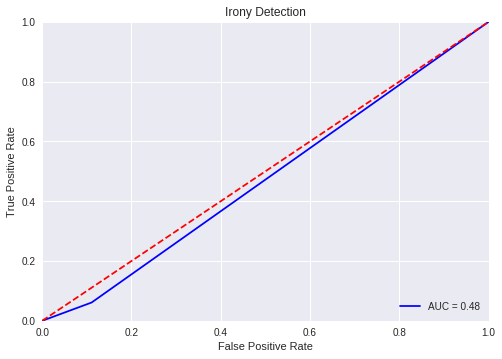

In [0]:
model = load_model("final_model_old.hdf5")

y_test=[]
y_pred=[]

#creating zero array of length 1 and size 5 to store the values of input vector.
x = np.zeros((1,num_steps))
for tweet in test:
    comb_predict_list=[] 
    #As the step_size of our model is 5, we divide each tweet into a combination of 5 words. 
    #We then predict the class label of each of these combinations. We combine the max probability 
    # of all these individual tweet combinations into single number 1 or 0. Finally, we get a list of 
    # class predictions per tweet.
    for tweet_comb in get_ngrams(tweet[2]):
        w = np.array([])
        for word in tweet_comb:
            w=np.hstack((w, vocabulary[word]))
        
        x[0,:]=w
        comb_predict_list.append(get_max_prediction(model.predict_classes(x)))
    y_pred.append(get_max_prediction_list(comb_predict_list))
    y_test.append(int(tweet[1]))

evaluate_performance(y_test, y_pred)

# Task 5

Suggest an improvement to either the system developed in Task 2 or 4 and show that it improves according to your evaluation metric.

### Explanation

* In the existing scenario, the multi-class classification was used as the loss function. The multi-class classification should only be used when there are more than two exclusive targets.
 
* The accuracy computed with the Keras method evaluate is just plain wrong when using categorical cross-entropy with 2 labels. We can check above fact by recomputing the accuracy (first call the Keras method "predict" and then compute the number of correct answers returned by predict): you get the true accuracy, which is much lower than the Keras "evaluate" one.

* For Binary classification with two target classes, binary cross-entropy should be used and targets encoded as one-hot vectors. The accuracy type of metric should be accuracy.

* Also, the activation function should be selected as follows:

  * **binary_crossentropy**: sigmoid activation
  * **categorical_crossentropy**: softmax activation
  
* Our task is a binary classification, the last layer will be a dense layer with a sigmoid activation function.

* Dropout can be applied between layers using the Dropout Keras layer. It is a powerful technique for combating overfitting in your LSTM models. It has an impact on our model with the accuracy slightly on the higher side. We have lowered our dropout value to 0.2

* The number of hidden layers affects the learning capacity of the network. More hidden layers would be able to learn more structure from the problem at the cost of longer training time. On the hand, more layers also result in overfitting of the model. In our case, we have increased the size of the hidden layer to 100.

* In Keras, the batch size must be a factor of the size of the test and the training dataset. The batch size was fixed at 5 in the previous case. Here we have updated our batch size to be 64

* **If we compare the ROC curve for both the models, we see that the curve has slightly shifted towards the diagonal. Consequently, accuracy has increased from 0.47739 to 0.49304**

* Following are the findings from the confusion matrix (Improved Model).

    * The total actual irony tweets in the dataset is the sum of the values (53 + 42)
    * The total actual non irony tweets in the dataset is the sum of values (525 + 530).
    * The correct values are organized in a diagonal line from top left to bottom-right of the matrix (525 + 42).
    * More errors were made by predicting irony tweets as irony than predicting irony as non irony.


In [0]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Embedding, Dropout, TimeDistributed
from keras.layers import LSTM
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

## These values should be set from Task 3
train, test = task3()

def make_dictionary(train, test):
    dictionary = {}
    for d in train+test:
        for w in d[2]:
            if w not in dictionary:
               dictionary[w] = len(w)
    return dictionary

class KerasBatchGenerator(object):
    def __init__(self, data, num_steps, batch_size, vocabulary, skip_step=5):
        self.data = data
        self.num_steps = num_steps
        self.batch_size = batch_size
        self.vocabulary = vocabulary
        self.current_idx = 0
        self.current_sent = 0
        self.skip_step = skip_step

    def generate(self):
        x = np.zeros((self.batch_size, self.num_steps))
        y = np.zeros((self.batch_size, self.num_steps, 2))
        while True:
            for i in range(self.batch_size):
                # Choose a sentence and position with at lest num_steps more words
                while self.current_idx + self.num_steps >= len(self.data[self.current_sent][2]):
                    self.current_idx = self.current_idx % len(self.data[self.current_sent][2])
                    self.current_sent += 1
                    if self.current_sent >= len(self.data):
                        self.current_sent = 0
                # The rows of x are set to values like [1,2,3,4,5]
                x[i, :] = [self.vocabulary[w] for w in self.data[self.current_sent][2][self.current_idx:self.current_idx + self.num_steps]]
                # The rows of y are set to values like [[1,0],[1,0],[1,0],[1,0],[1,0]]
                y[i, :, :] = [[self.data[self.current_sent][1], 1-self.data[self.current_sent][1]]] * self.num_steps
                self.current_idx += self.skip_step
            yield x, y

# Hyperparameters for model
vocabulary = make_dictionary(train, test)
num_steps = 5
batch_size = 64
num_epochs = 50 # Reduce this if the model is taking too long to train (or increase for performance)
hidden_size = 100 # Increase this to improve perfomance (or increase for performance)
use_dropout=True

# Create batches for RNN
train_data_generator = KerasBatchGenerator(train, num_steps, batch_size, vocabulary,
                                           skip_step=num_steps)
valid_data_generator = KerasBatchGenerator(test, num_steps, batch_size, vocabulary,
                                           skip_step=num_steps)

# A double stacked LSTM with dropout and n hidden layers
model = Sequential()
model.add(Embedding(len(vocabulary), hidden_size, input_length=num_steps))
model.add(LSTM(hidden_size, return_sequences=True))
model.add(LSTM(hidden_size, return_sequences=True))
if use_dropout:
    model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(2)))
model.add(Activation('sigmoid'))

# Set optimizer and build model
optimizer = Adam()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

# Train the model
model.fit_generator(train_data_generator.generate(), len(train)//(batch_size*num_steps), num_epochs,
                        validation_data=valid_data_generator.generate(),
                        validation_steps=len(test)//(batch_size*num_steps))

# Save the model
model.save("final_model.hdf5")

The confusion matrix: 

Predicted     0   1   All
Gold                     
0           525  53   578
1           530  42   572
All        1055  95  1150

Accuracy: 0.49304
Error Rate: 0.51
Precision: 0.91
F-measure: 0.64

ROC Curve:


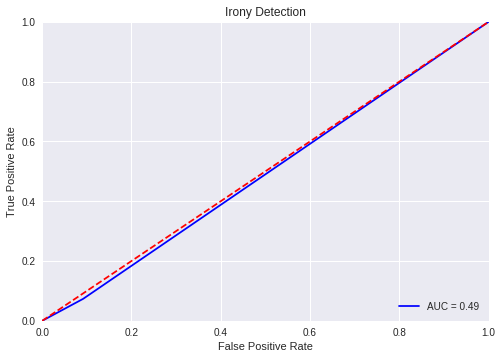

In [0]:
model = load_model("final_model.hdf5")

y_test=[]
y_pred=[]

#creating zero array of length 1 and size 5 to store the values of input vector.
x = np.zeros((1,num_steps))
for tweet in test:
    comb_predict_list=[] 
    #As the step_size of our model is 5, we divide each tweet into a combination of 5 words. 
    #We then predict the class label of each of these combinations. We combine the max probability 
    # of all these individual tweet combinations into single number 1 or 0. Finally, we get a list of 
    # class predictions per tweet.
    for tweet_comb in get_ngrams(tweet[2]):
        w = np.array([])
        for word in tweet_comb:
            w=np.hstack((w, vocabulary[word]))
        
        x[0,:]=w
        comb_predict_list.append(get_max_prediction(model.predict_classes(x)))
    y_pred.append(get_max_prediction_list(comb_predict_list))
    y_test.append(int(tweet[1]))

evaluate_performance(y_test, y_pred)

### Conclusion

* We can still increase the accuracy of our model by increasing the vocabulary size, add more training samples, add regularization, improved pre-processing stage and so on.

### References

* Keras.io. (2019). Home - Keras Documentation. [online] Available at: https://keras.io/ [Accessed 1 Mar. 2019].
* Stack Overflow. (2019). Keras binary_crossentropy vs categorical_crossentropy performance?. [online] Available at: https://stackoverflow.com/questions/42081257/keras-binary-crossentropy-vs-categorical-crossentropy-performance [Accessed 1 Mar. 2019].